# 4.2
## 2.

### Imports

In [53]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### Obter série de anos

In [54]:
years = pd.Series([i for i in range(1900, 2021)])

seed_value = 55
sampleyears2 = years.sample(n=12, replace=False, random_state=seed_value)

seed_value = 85
sampleyears3 = years.sample(n=12, replace=False, random_state=seed_value)

### Ler os dados

In [55]:
dados_lidos = pd.read_csv("CO_data.csv")

### Inspecionar os dados

Nota: A análise destes dados já foi realizada na primeira parte do trabalho, pelo que nesta parte fica apenas uma "verificação" visual do carregamento dos dados.

In [56]:
dados_lidos.head()

,country,year,population,gdp,cement_co2,co2,coal_co2,energy_per_capita,energy_per_gdp,flaring_co2,gas_co2,methane,nitrous_oxide,oil_co2
0,Afghanistan,1900,4707744.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,4751177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,4802500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,4861833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,4921891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Obter dados dos anos pretendidos para Portugal e Hungria

Vamos realizar a filtragem das linhas e colunas de uma única vez, pelo que precisamos de preparar os filtros previamente.
Optámos também por ter os dados em 2 datasets separados por País, neste caso não existe vantagem em ter apenas um único dataset para todos os dados.

In [57]:
# Definição das condições de filtragem.
condicao_anos_PT = dados_lidos.year.isin(list(sampleyears2))
condicao_anos_HU = dados_lidos.year.isin(list(sampleyears3))
condicao_PT = dados_lidos.country == "Portugal"
condicao_HU = dados_lidos.country == "Hungary"

# Extrair dos dados lidos, os dados de trabalho de acordo com as condições de filtro.
dados_PT = dados_lidos.loc[condicao_PT & condicao_anos_PT, ["year", "gdp"]]
dados_HU = dados_lidos.loc[condicao_HU & condicao_anos_HU, ["year", "gdp"]]

### Tratar dos NaN

Optámos por remover do dataset os registos com os valores ``NaN``.

In [58]:
dados_PT.dropna(inplace=True)
dados_HU.dropna(inplace=True)

### Inspecionar dados filtrados

In [59]:
dados_PT.head()

,year,gdp
24465,1909,1.123628e+10
24479,1923,1.461160e+10
24496,1940,1.975545e+10
24497,1941,2.160324e+10
24523,1967,6.502273e+10


In [60]:
dados_HU.head()

,year,gdp
13448,1910,2.436907e+10
13464,1926,2.888782e+10
13484,1946,2.480221e+10
13498,1960,5.806411e+10
13508,1970,8.285109e+10


### Gráficos dos dados

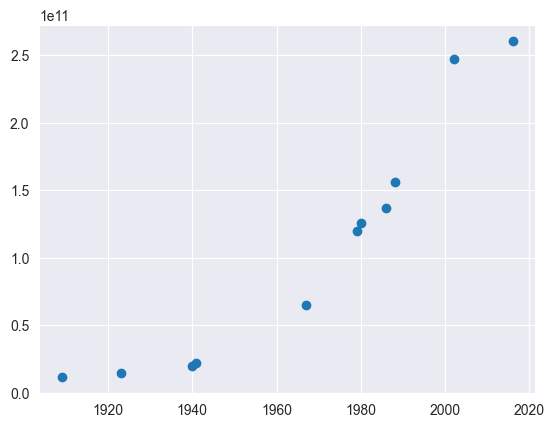

In [61]:
plt.scatter(dados_PT["year"], dados_PT["gdp"])

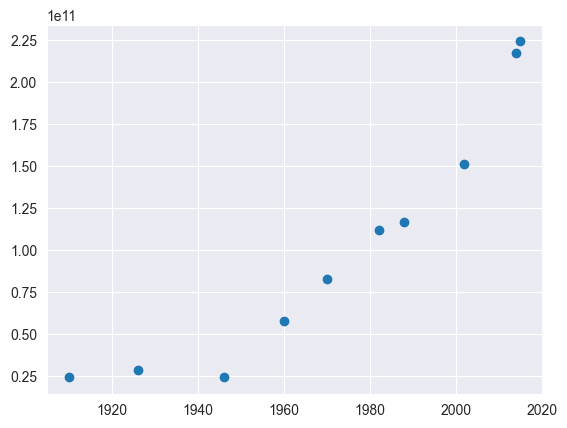

In [62]:
plt.scatter(dados_HU["year"], dados_HU["gdp"])

### Cálcular a média amostral

In [63]:
# Média amostral de Portugal.
media_PT = dados_PT["gdp"].mean(axis=0)
print(f"Média amostral de Portugal: {media_PT:.4e}")

# Média amostral da Hungria.
media_HU = dados_HU["gdp"].mean(axis=0)
print(f"Média amostral da Hungria: {media_HU:.4e}")

Média amostral de Portugal: 1.0705e+11
Média amostral da Hungria: 1.0413e+11


### Normalidade

O teste à normalidade *stats.normaltest()* é para amostras de dimensão superior a 20.
Temos de utilizar *stats.shapiro()* 

In [64]:
statval_PT, p_value_PT = stats.shapiro(dados_PT["gdp"])
print(f"Portugal - pvalue: {p_value_PT:.3}")

statval_HU, p_value_HU = stats.shapiro(dados_HU["gdp"])
print(f"Hungria - pvalue: {p_value_HU:.3}")


Portugal - pvalue: 0.115
Hungria - pvalue: 0.188


Como o *p-value* de Portugal é superior a 5% os dados seguem distribuição normal.
Como o *p-value* da Hungria é superior a 5% os dados seguem distribuição normal. 

### Calcular a variância

In [65]:
variancia_PT = dados_PT["gdp"].var(axis=0)
print(f"Variância para os dados de Portugal: {variancia_PT:.3e}")
variancia_HU = dados_HU["gdp"].var(axis=0)
print(f"Variância para os dados de Hungria: {variancia_HU:.3e}")

Variância para os dados de Portugal: 8.133e+21
Variância para os dados de Hungria: 5.624e+21


### Homogeneidade

Precisamos de averiguar fazer um teste de **Levene** ás variâncias para verificar se são iguais para decidir qual o teste à média a realizar.

$$H_0: \mu_{PT} = \mu_{HU} \quad Vs \quad H_1: \mu_{PT} \neq \mu_{HU}$$ 

In [66]:
resultado_levene = stats.levene(dados_PT["gdp"], dados_HU["gdp"])
print(f"Valor da estatistica de teste: {resultado_levene.statistic:.3} \np-value: {resultado_levene.pvalue:.3}")

Valor da estatistica de teste: 0.34 
p-value: 0.567


Como o *p-value* é superior a 5% não rejeitamos a hipótese nula, ou seja vamos assumir que as variâncias são iguais. 

### Teste à média

#### Hipotese

$$H_0: \bar X_{PT} \geq \bar X_{HU} \quad Vs \quad H_1: \bar X_{PT} < \bar X_{HU}$$

Amostras não emparelhadas (independentes).
Tamanho da amostra é reduzido.
Distribuição normal.
Pela análise do gráfico não parecem existir outliers significativos.

Utilização de **ttest_ind()** com *equal_var=True* à média.


In [67]:
f_stat, p_value = stats.ttest_ind(dados_PT["gdp"], dados_HU["gdp"], equal_var=True)
print(f"Valor da estatistica de teste: {f_stat:.3} \np-value: {p_value:.3}")

Valor da estatistica de teste: 0.0802 
p-value: 0.937


Com o *p-value* do teste de 0,937 não vamos rejeitar a hipótese nula, ou seja aceitamos que a média do **GDP** de Portugal é superior ao **GDP** da Hungria, nas amostras consideradas.

### Exploração de metodologia 

In [68]:
f_stat, p_value = stats.f_oneway(dados_PT["gdp"], dados_HU["gdp"])
print(f"Valor da estatistica de teste: {f_stat:.3} \np-value: {p_value:.3}")

Valor da estatistica de teste: 0.00643 
p-value: 0.937


### Gráfico Boxplot

Text(0, 0.5, 'GDP ($)')

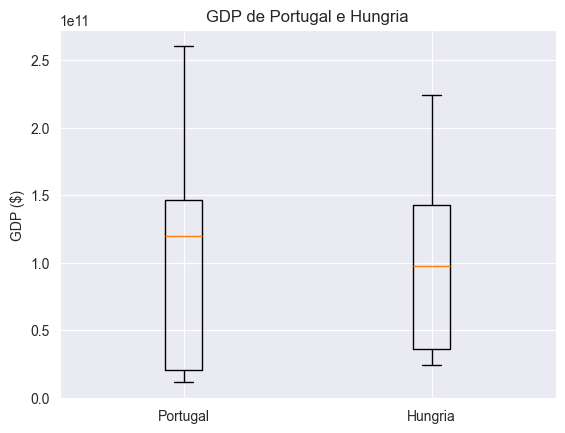

In [69]:
fig_bp, ax_bp = plt.subplots()
ax_bp.boxplot([dados_PT["gdp"], dados_HU["gdp"]], labels=["Portugal", "Hungria"])
ax_bp.set_title("GDP de Portugal e Hungria")
ax_bp.set_ylabel("GDP ($)")

# fig_bp.show()  # Em Jupyter pode apresentar um aviso.